In [311]:
import os
import pathlib
from typing import List, Tuple
from dotenv import load_dotenv
from setup_logger import logger
import cv2 as cv

BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [312]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy as np
import matplotlib.colors as colors
from typing import List, Tuple

## Generate plot data

In [236]:
generated_plots_savepath = DATA_PATH / "generated_plots"

In [237]:
colors_list = list(colors._colors_full_map.values())[:1150]
marker_types = [".", "o", "v", "^", "<", ">", "1", "s", "p", "P", "*", "+", "X", "D", "d"]
marker_sizes = [60, 70, 80, 90, 100, 110]

distributions = [
    sps.uniform(loc=1, scale=8), 
    sps.expon(loc=0, scale=1.5), 
    sps.norm(loc=5, scale=1)
]

In [238]:
def generate_points(n: int, distributions: List):
    distr_x, distr_y = np.random.choice(distributions, size=2)
    x = distr_x.rvs(size=n)
    y = distr_y.rvs(size=n)
    
    return x, y

In [302]:
def generate_single_plot():
    fig = plt.figure(figsize=(8, 8))

    markersize = np.random.choice(marker_sizes)
    all_points = []

    for j in range(3):
        x, y = generate_points(50, distributions)
        points_single_marker = np.stack((x, y)).T

        color = np.random.choice(colors_list)
        marker = np.random.choice(marker_types)
        plt.scatter(x, y,
                    s=markersize,
                    c=color,
                    marker=marker,
                    cmap=None,
                    edgecolors='black',
                    linewidths=0.6,
                    label=f"Label {j}")
        all_points.append(points_single_marker)
    plt.title("Title")
    plt.xlabel("X label")
    plt.ylabel("Y label")
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)
    plt.grid()
    plt.legend()

    return fig, all_points

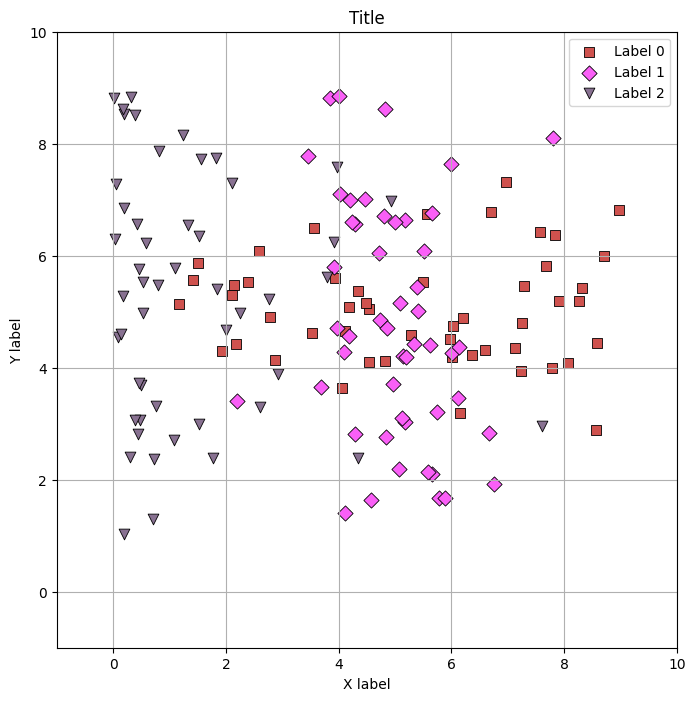

In [261]:
fig, all_points = generate_single_plot()

**Generate many plots**

In [262]:
def coordinates_to_px(x, y):
    delta_x = 113
    delta_y = 32
    s_x = 56.4
    s_y = 56
    max_y = 10

    x_px = delta_x + x * s_x
    y_px = delta_y + (max_y - y) * s_y
    return x_px, y_px

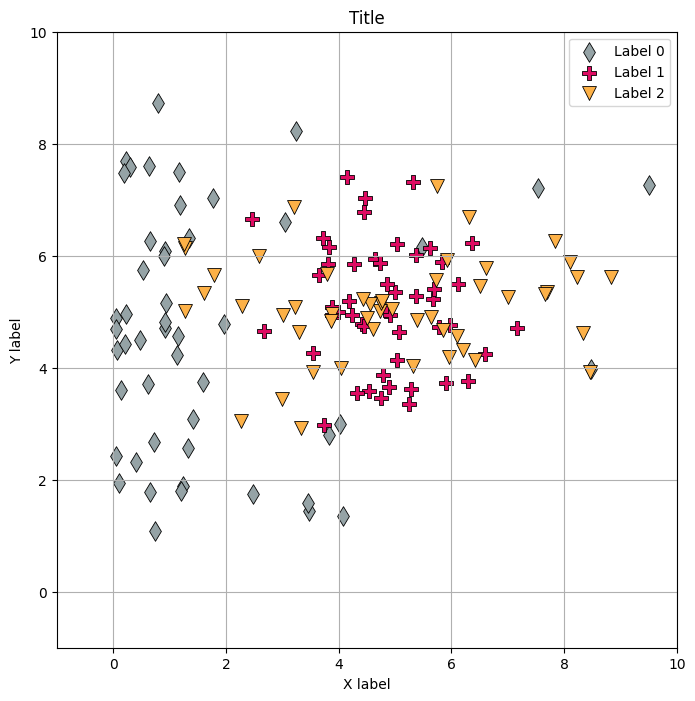

In [309]:
for i in range(13, 14):
    fig, all_points = generate_single_plot()

    for marker_num in range(len(all_points)):
        marker_points = all_points[marker_num]

        x, y = marker_points[:, 0], marker_points[:, 1]
        x_px, y_px = coordinates_to_px(x, y)
        marker_points_px = np.stack((x_px, y_px)).T

        np.savetxt(
            generated_plots_savepath / f"plot_{i}_coordinates_marker_{marker_num}.csv",
            marker_points_px,
            delimiter=",")
    fig.savefig(generated_plots_savepath / f"plot_{i}.png", bbox_inches="tight")

## Map generated points coordinates to pixel coordinates

In [123]:
points = np.loadtxt(
    generated_plots_savepath / "plot_0_coordinates_marker_0.csv", 
    dtype=np.float64, 
    delimiter=","
)

In [126]:
# x, y = points[:, 0], points[:, 1]

# # podgon
# delta_x = 113
# delta_y = 32
# s_x = 56.4
# s_y = 56
# max_y = 10

# x = delta_x + x * s_x
# y = delta_y + (max_y - y) * s_y

In [127]:
img = plt.imread(generated_plots_savepath / "plot_0.png")

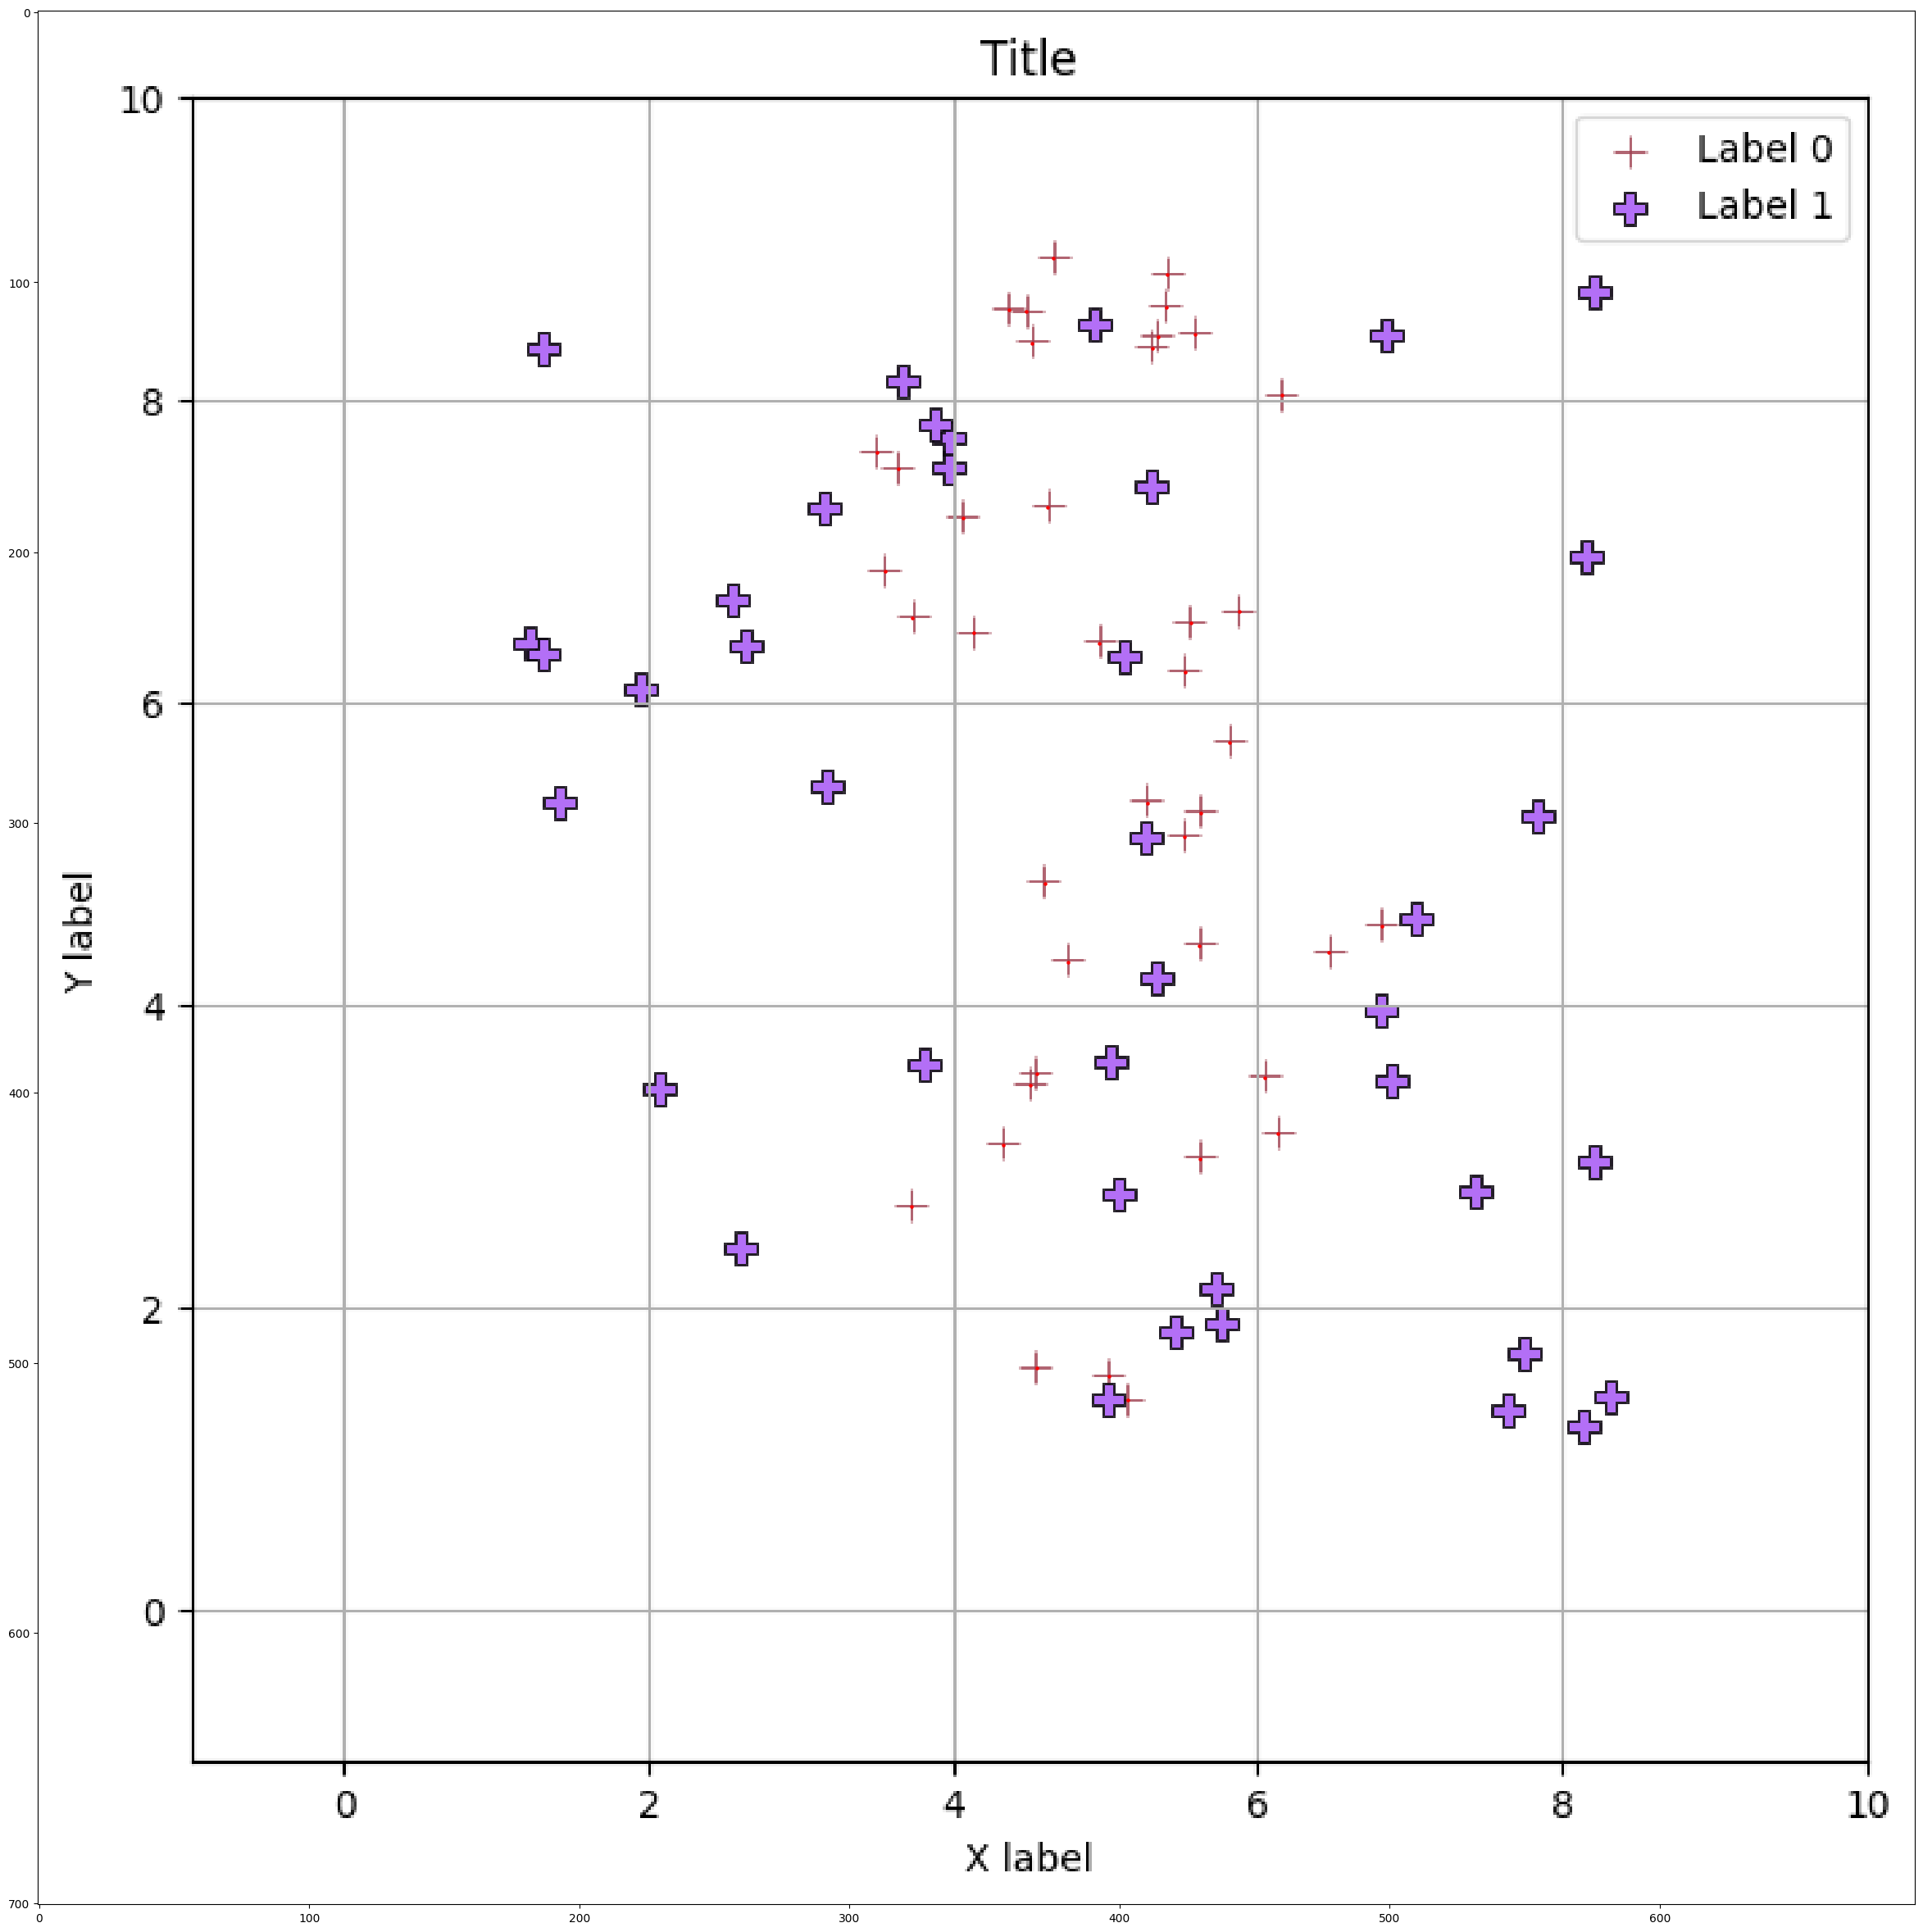

In [128]:
plt.figure(figsize=(30, 30))

plt.imshow(img)

plt.scatter(x, y, color="red", s=5)

## Estimate quiality

In [313]:
TRUE_POINTS_PATH = DATA_PATH / "generated_plots"
DETECTED_POINTS_PATH = DATA_PATH / "generated_plots" / "detected_coordinates"

In [476]:
PLOT_NUMBER = 5
MARKER_NUMBER = 2

PLOT_PATH = TRUE_POINTS_PATH / f"plot_{PLOT_NUMBER}.png"

points_true = np.loadtxt(
    TRUE_POINTS_PATH / f"plot_{PLOT_NUMBER}_coordinates_marker_{MARKER_NUMBER}.csv", 
    dtype=np.float64, 
    delimiter=","
)

points_detected = np.loadtxt(
    DETECTED_POINTS_PATH / f"plot_{PLOT_NUMBER}_detected_coordinates_marker_{MARKER_NUMBER}.csv", 
    dtype=np.float64, 
    delimiter=","
)

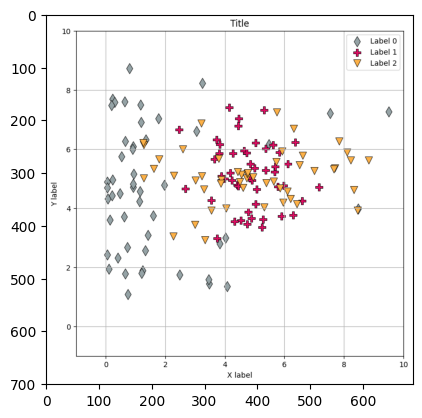

In [477]:
source_image = img = cv.imread(str(PLOT_PATH))

plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Detected points')

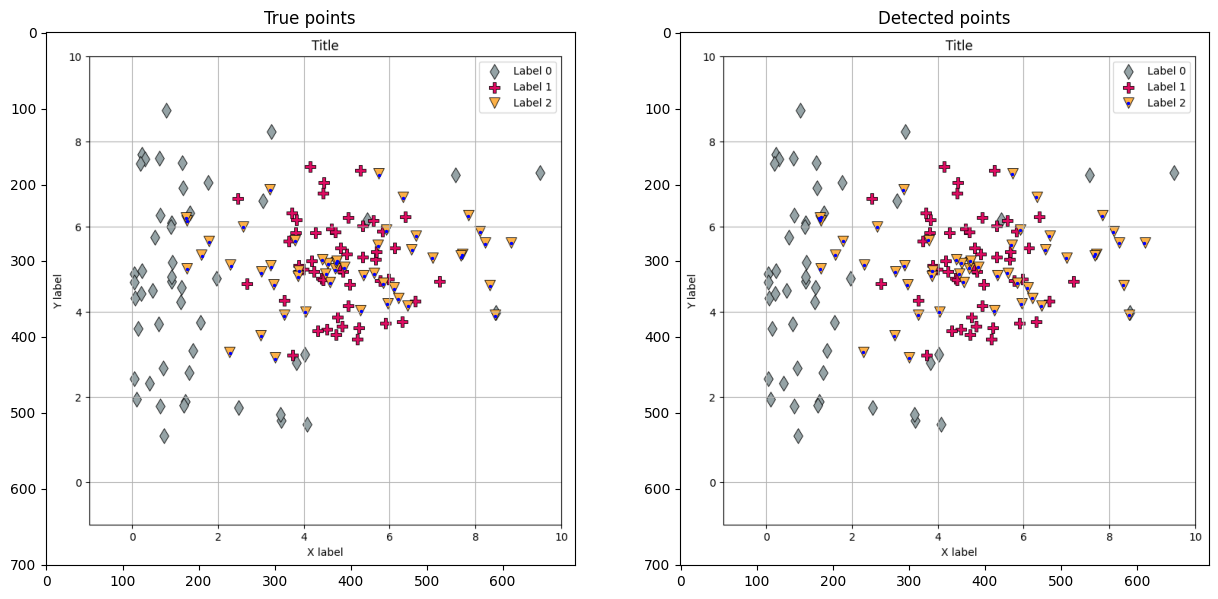

In [478]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))
plt.scatter(points_true[:, 0], points_true[:, 1], s=2, color="blue")
plt.title("True points")

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))
plt.scatter(points_detected[:, 0], points_detected[:, 1], s=2, color="blue")
plt.title("Detected points")

In [479]:
from scipy.spatial import distance

def compute_distances(points: np.ndarray, target_point: Tuple[float, float]) -> float:

    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        distances[i] = distance.euclidean(point, target_point)
    
    return distances

In [492]:
quality_tolerance_px = 4
detected_points_counts = []


for true_point in points_true:
    distances = compute_distances(points_detected, true_point)
    
    # amount of detected points near true point
    points_count = np.sum(distances < quality_tolerance_px)
    detected_points_counts.append(points_count)
    
detected_points_counts = np.array(detected_points_counts)

In [493]:
quality_tolerance_px = 4
true_points_counts = []


for detected_point in points_detected:
    distances = compute_distances(points_true, detected_point)
    
    # amount of true points near detected point
    points_count = np.sum(distances < quality_tolerance_px)
    true_points_counts.append(points_count)
    
true_points_counts = np.array(true_points_counts)

In [494]:
true_points_counts

array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2])

In [495]:
detected_points_counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [496]:
successfully_detected_points_count = len(np.where(detected_points_counts == 1)[0])
missed_points_count = len(np.where(detected_points_counts == 0)[0])
overdetected_points_count = len(np.where(detected_points_counts > 1)[0])
fake_detection_count = len(np.where(true_points_counts == 0)[0])

print("Successfull detection percentage:", successfully_detected_points_count / len(points_true))
print()
print("Number of true points, that were not detected:", missed_points_count)
print("Number of true points, that has more than one detection:", overdetected_points_count)
print("Number of detected points, that has wrong detection:", fake_detection_count)

Successfull detection percentage: 0.94

Number of true points, that were not detected: 0
Number of true points, that has more than one detection: 3
Number of detected points, that has wrong detection: 1
